In [1]:
import os
import pandas as pd
import cv2
from tqdm import tqdm  # Import tqdm for progress bar

# Input and output directories for both train and validation
DATA_DIRS = {
    'train': "/kaggle/input/sportsmot/sportsmot_publish/dataset/train",
    'val': "/kaggle/input/sportsmot/sportsmot_publish/dataset/val"
}

OUTPUT_IMG_DIRS = {
    'train': "/kaggle/working/train/images",
    'val': "/kaggle/working/val/images"
}

OUTPUT_LABEL_DIRS = {
    'train': "/kaggle/working/train/labels",
    'val': "/kaggle/working/val/labels"
}

# Create directories if they don't exist
for split in ['train', 'val']:
    os.makedirs(OUTPUT_IMG_DIRS[split], exist_ok=True)
    os.makedirs(OUTPUT_LABEL_DIRS[split], exist_ok=True)

# Image dimensions (assumed for normalization, update based on actual data)
IMG_WIDTH = 1280  # Replace with actual image width
IMG_HEIGHT = 720  # Replace with actual image height

# Function to convert bounding boxes to YOLO format
def to_yolo_format(x, y, w, h, img_w, img_h):
    xc = (x + w / 2) / img_w
    yc = (y + h / 2) / img_h
    w = w / img_w
    h = h / img_h
    return xc, yc, w, h

# Process both train and validation directories
for split, data_dir in DATA_DIRS.items():
    print(f"Processing {split} data...")
    
    # Iterate through video directories with tqdm for progress bar
    for video_dir in tqdm(sorted(os.listdir(data_dir)), desc=f"Processing {split} videos", unit="video"):
        video_path = os.path.join(data_dir, video_dir)
        gt_file = os.path.join(video_path, 'gt/gt.txt')
        img_dir = os.path.join(video_path, 'img1')
        
        # Load ground truth file
        det_df = pd.read_csv(gt_file, header=None, names=['frame', 'id', 'x', 'y', 'w', 'h', 'f1', 'f2', 'f3'])
        
        # Group by frames with tqdm for progress bar
        for frame_num, frame_data in tqdm(det_df.groupby('frame'), desc=f"Processing frames for {video_dir}", unit="frame"):
            # Frame image path
            img_file = f"{img_dir}/{frame_num:06}.jpg"
            if not os.path.exists(img_file):
                continue  # Skip if image does not exist
            
            # Copy image to output directory for this split (train/val)
            dst_img_file = f"{OUTPUT_IMG_DIRS[split]}/{video_dir}_{frame_num:06}.jpg"
            if not os.path.exists(dst_img_file):
                os.symlink(img_file, dst_img_file)
            
            # Create label file for this frame in the corresponding directory
            label_file = f"{OUTPUT_LABEL_DIRS[split]}/{video_dir}_{frame_num:06}.txt"
            with open(label_file, 'w') as f:
                for _, row in frame_data.iterrows():
                    xc, yc, w, h = to_yolo_format(row['x'], row['y'], row['w'], row['h'], IMG_WIDTH, IMG_HEIGHT)
                    f.write(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")


Processing train data...


Processing train videos: 100%|██████████| 45/45 [01:07<00:00,  1.49s/video]


Processing val data...


Processing val videos: 100%|██████████| 45/45 [01:48<00:00,  2.42s/video]


# Check annotations

In [4]:
import os
import random
import cv2

# Path to the images and labels directory
IMG_DIR = "/kaggle/working/train/images"  # Replace with the correct images directory
LABEL_DIR = "/kaggle/working/train/labels"  # Replace with the correct labels directory
OUTPUT_ANNOTATED_DIR = "/kaggle/working/annotated_images"  # Directory to save annotated images

# Create directory for annotated images if it doesn't exist
os.makedirs(OUTPUT_ANNOTATED_DIR, exist_ok=True)

# Get a random image file from the directory
random_img_file = random.choice(os.listdir(IMG_DIR))
image_path = os.path.join(IMG_DIR, random_img_file)

# Corresponding label file
label_file = random_img_file.replace('.jpg', '.txt')
label_path = os.path.join(LABEL_DIR, label_file)

# Read the image
img = cv2.imread(image_path)
height, width, _ = img.shape

# Annotate the image with the bounding boxes from the YOLO labels
if os.path.exists(label_path):
    print(f"Annotating {random_img_file}...")
    with open(label_path, 'r') as f:
        annotations = f.readlines()
        
        # Draw each bounding box on the image
        for ann in annotations:
            class_id, xc, yc, w, h = map(float, ann.strip().split())
            
            # Convert from YOLO format to pixel values
            x1 = int((xc - w / 2) * width)
            y1 = int((yc - h / 2) * height)
            x2 = int((xc + w / 2) * width)
            y2 = int((yc + h / 2) * height)
            
            # Draw a rectangle on the image
            color = (0, 255, 0)  # Green color for the bounding box
            thickness = 2  # Thickness of the bounding box
            img = cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    
    # Save the annotated image
    annotated_image_path = os.path.join(OUTPUT_ANNOTATED_DIR, f"annotated_{random_img_file}")
    cv2.imwrite(annotated_image_path, img)
    print(f"Annotated image saved to {annotated_image_path}")
else:
    print(f"No annotations found for {random_img_file}")


Annotating v_1yHWGw8DH4A_c077_000535.jpg...
Annotated image saved to /kaggle/working/annotated_images/annotated_v_1yHWGw8DH4A_c077_000535.jpg


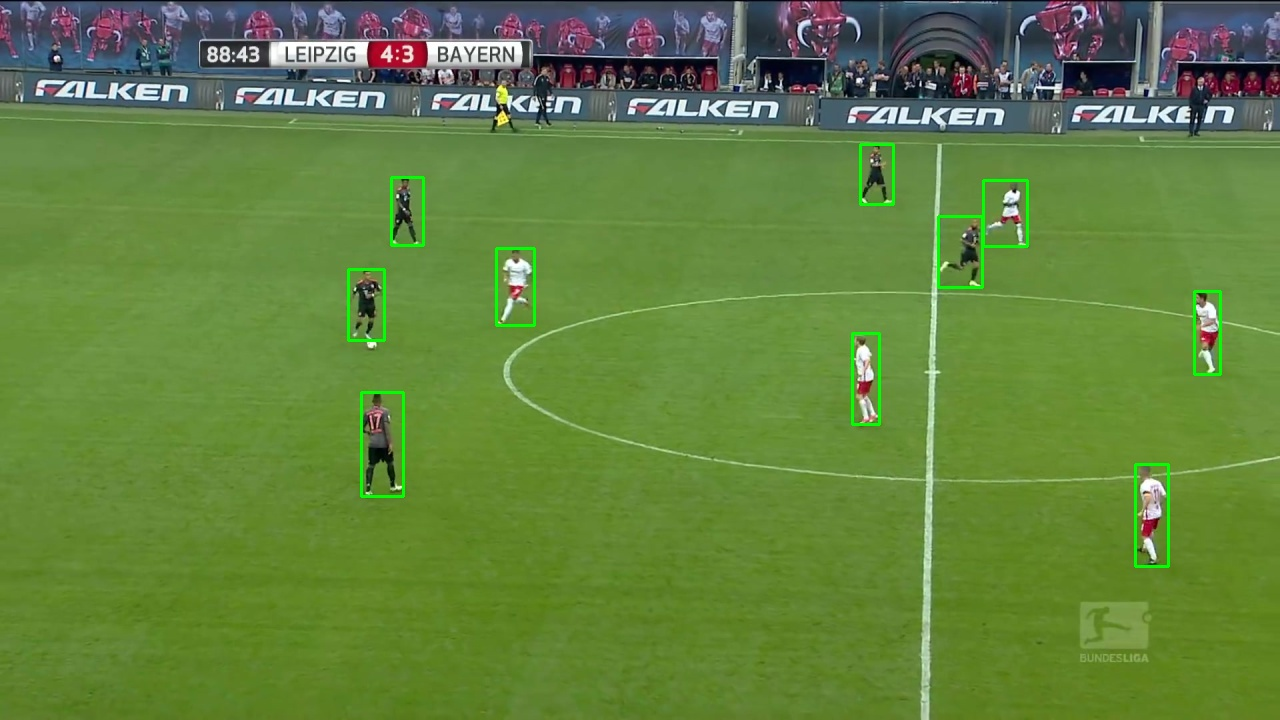

In [6]:
from PIL import Image
from IPython.display import display
pil_img = Image.open("/kaggle/working/annotated_images/annotated_v_1yHWGw8DH4A_c077_000535.jpg")
display(pil_img)